In [42]:
import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
# import ruamel.yaml
import yaml
import re
import ast

import math
import sys
import traceback
from csv import excel
from collections import Counter
from scipy.stats import rankdata

# test_name = "1p9f9s_run"
# test_name = "seq6f3s"
# test_name = "seq9f9s"
test_name = "arldm"

stat_path=f"../example_stat/{test_name}"
iamge_path=f"{stat_path}/images"



# Improve Functions
## TODO
- (Maybe) Add adjustment of label to full label, file-task label, and no lables
- add VFD stats for file node
- Maps dataset y-axis with blob number as the position, x-axis with first access time

## Maybe
- add option to filter dataset nodes networkx graph (to reduce graph size)

## DONE
- DONE:Add task cutoff option for graphs
- Add task start option for graphs
    - Be careful about adding the required files??!!
- some read_only edges seems wrong direction (maybe `set_task_file_dset_pos`)

In [43]:
SELECT_STAGE_START = 0
SELECT_STAGE_END = 1

# TODO: get TASK_ORDER_LIST from task-file yaml file

TASK_ORDER_LIST = {"arldm_train": 0,}

# TASK_ORDER_LIST = {
#     "run_idfeature": 0,
#     "run_tracksingle": 1,
#     "run_gettracks": 2,
#     "run_trackstats": 3,
#     "run_identifymcs": 4,
#     "run_matchpf": 5,
#     "run_robustmcs": 6,
#     "run_mapfeature": 7,
#     "run_speed": 8
# }

# TASK_ORDER_LIST = {
#     "openmm-0000": 0,"openmm-0001": 0,"openmm-0002": 0,
#     "openmm-0003": 0,"openmm-0004": 0,"openmm-0005": 0,
#     "openmm-0006": 0,"openmm-0007": 0,"openmm-0008": 0,
#     "openmm-0009": 0,"openmm-0010": 0,"openmm-0011": 0,
#     "aggregate": 1,
#     "train": 2,
#     "inference": 3,
# }

def correct_end_stage(select_end):
    # check if SELECT_STAGE_END is in TASK_ORDER_LIST
    max_order = max(TASK_ORDER_LIST.values())
    if select_end > max_order:
        # raise ValueError("SELECT_STAGE_END is not in TASK_ORDER_LIST")
        select_end = max_order
        print("SELECT_STAGE_END is not in TASK_ORDER_LIST, set to max order: {}".format(max_order))
    return select_end

SELECT_STAGE_END = correct_end_stage(SELECT_STAGE_END)

def remove_unwanted_tasks(map_dict):
    """Remove unwanted tasks from dictionary"""
    for task in list(map_dict.keys()):
        if task not in TASK_LISTS:
            map_dict.pop(task)
    return map_dict

TASK_LISTS = []
for task, order in TASK_ORDER_LIST.items():
    if SELECT_STAGE_END == -1:
        TASK_LISTS = list(TASK_ORDER_LIST.keys())
    else:
        if order <= SELECT_STAGE_END and order >= SELECT_STAGE_START:
            TASK_LISTS.append(task)



TASK_LISTS


SELECT_STAGE_END is not in TASK_ORDER_LIST, set to max order: 0


['arldm_train']

In [70]:

import os
import re

# data and load related methods
def humansize(nbytes):
    if nbytes != 0:
        suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
        i = 0
        while nbytes >= 1000 and i < len(suffixes)-1:
            nbytes /= 1000.
            i += 1
        f = ('%.2f' % nbytes).rstrip('0').rstrip('.')

        return '%s %s' % (f, suffixes[i])
    else:
        return 0

def humanbw(nbytes):
    if nbytes != 0:
        suffixes = ['B/s', 'KB/s', 'MB/s', 'GB/s', 'TB/s', 'PB/s']
        i = 0
        while nbytes >= 1000 and i < len(suffixes)-1:
            nbytes /= 1000.
            i += 1
        f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
        return '%s %s' % (f, suffixes[i])
    else:
        return 0

def load_vol_yaml(vol_files):
    ret_dict = {}
    tmp_dict = {}
    for f in vol_files:
        if '.yaml' in f or '.yml' in f:
            with open(f, "r") as stream:
                print(f"loading {f}")
                try:
                    tmp_dict = yaml.safe_load(stream)
                    # print(tmp_dict)
                except yaml.YAMLError as exc:
                    print(exc)
                ret_dict[f] = tmp_dict
    return ret_dict

        
def search_files_with_name(directory, pattern):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if re.search(pattern, file) and ('.yaml' in file or '.yml' in file):
                file_list.append(os.path.join(root, file))
                #print(os.path.join(root, file))
    return file_list

# Read in task_to_file mapping yaml file
def load_task_file_map(test_name):
    task_file_map = {}
    with open(f"{stat_path}/{test_name}-task_to_file.yaml", "r") as stream:
        try:
            task_file_map = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return task_file_map


def display_all_nodes_attr(G):
    for node in G.nodes():
        print(f"Node Name: {node}")
        # print(f"- Statistics: {G.nodes[node]}")
        print(f"- Order: {G.nodes[node]['order']} - Type: {G.nodes[node]['type']} - Position: {G.nodes[node]['pos']}")
        print(f"- Statistics: {G.nodes[node]['stat']}")
    if len(G.nodes()) == 0:
        print("No node in graph")


In [73]:
# Graph Related Code

def draw_graph(G, test_name, prefix="", save=False):
    plt.figure(figsize=(80, 20))
    pos = {node: data['pos'] for node, data in G.nodes(data=True)}
    # Draw the graph with node labels
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray')

    if save:
        out_file_name=f"{test_name}-vol-networkx.png"
        if prefix != "": out_file_name=f"{prefix}-{test_name}-vol-networkx.png"
        
        save_image_path=f"../example_stat/{test_name}/{out_file_name}"
        plt.savefig(save_image_path)
    
    # Show the graph
    plt.show()

def set_task_position(G, tfe_dic):
    skip_pos = 3
    task_start_pos = 2
    task_order_cnt = {}
    prev_task_order = 0
    # task_file_edges dictionay
    for task_name,v in tfe_dic.items():
        task_order = v['order']
        print(f"task_name: {task_name}, task_order: {task_order}")

        # Account for parallel tasks
        if task_order > prev_task_order:
            task_start_pos += skip_pos

        if task_order in task_order_cnt:
            task_order_cnt[task_order] += 1
        else:
            task_order_cnt[task_order] = 0
        
        if task_name in G.nodes:
            node_attrs = G.nodes[task_name]
            print(f"node {task_name} : {node_attrs}, pos: {node_attrs['pos']}")
            node_attrs['order'] = task_order # update task order
            node_attrs['pos'] = (task_start_pos,task_order_cnt[task_order]) # add task position
            if node_attrs['rpos'] == 0:
                node_attrs['rpos'] = 1 # add task position
                nx.set_node_attributes(G, node_attrs) # update node attributes
                print(f"node : {task_name}, pos: {node_attrs['pos']}")
            
        else:
            node_attrs = {task_name: {'rpos':1, 'order': task_order, 'type':'task', 'stat':v}}
            position = (task_order,task_order_cnt[task_order])
            G.add_node(task_name, pos=position)
            nx.set_node_attributes(G, node_attrs)
            print(f"node {task_name} : {node_attrs}, pos: {position}")
        
        prev_task_order = task_order


def add_task_dset_file_edges(G, stat_dict):
    node_order_list = {} # keeptrack of dataset order in each file
    edge_stats = {}
    access_cnt_dict = {}
    for stat_file, stat_list in stat_dict.items():
        print(stat_file)
        for li in stat_dict[stat_file]:
            k = list(li.keys())[0]
            if 'file' in k:
                parts = k.split("-")
                node_name = f"{k} : {li[k]['file_name']}"
                file_node_name = f"{li[k]['file_name']}"

                node_order = int(parts[1])
                if node_order not in node_order_list:
                    node_order_list[node_order] = 0
                # TODO: add dataset node and file node and edges
                if 'datasets' in li[k]:
                    
                    task_name = f"{li[k]['task_name']}"
                    if task_name in TASK_LISTS:

                        dset_node_stat = li[k]['datasets']
                        dset_node_name = f"{dset_node_stat['dset_name']}"
                        
                        # if dset_node_name == "lifestages":
                        #     print(f"lifestages: {dset_node_stat}")
                        if '/' in dset_node_name: dset_node_name = dset_node_name.replace('/', '')
                        
                        access_type = dset_node_stat['access_type']
                        dset_node_attrs = {}
                        # print(dset_node_attrs)
                        if access_type == 'read_only' or access_type == 'read_write':
                            # TODO: currently treating read_write as read_only (infer from VFD stat)
                            # file -> dset -> task
                            
                            dset_node_name = f"{dset_node_name}-read"
                            
                            if not G.has_node(file_node_name): # add file node
                                G.add_node(file_node_name, pos=(0,node_order))
                                file_node_attrs = {file_node_name: {'rpos':0, 'order': node_order, 'type':'file'}} # no stat here
                                nx.set_node_attributes(G, file_node_attrs)
                                
                            if not G.has_node(dset_node_name):  # add dataset node
                                G.add_node(dset_node_name, pos=(1,node_order_list[node_order]))
                                node_order_list[node_order] += 1
                                dset_node_attrs = {dset_node_name: {'rpos':0, 'order': node_order, 'type':'dataset'}}
                                nx.set_node_attributes(G, dset_node_attrs)
                            else:
                                if (file_node_name, dset_node_name) in access_cnt_dict.keys():
                                    access_cnt_dict[(file_node_name, dset_node_name)] += 1
                                else:
                                    access_cnt_dict[(file_node_name, dset_node_name)] = 0
                                
                                if (dset_node_name, task_name) in access_cnt_dict.keys():
                                    access_cnt_dict[(dset_node_name, task_name)] += 1
                                else:
                                    access_cnt_dict[(dset_node_name, task_name)] = 0


                            if not G.has_node(task_name):  # add task node
                                G.add_node(task_name, pos=(2,node_order))
                                # TODO: change to use VFD stats here
                                task_node_attrs = {task_name: {'rpos':0, 'order': node_order, 'type':'task'}}
                                nx.set_node_attributes(G, task_node_attrs)
                            
                            if not G.has_edge(file_node_name, dset_node_name):
                                G.add_edge(file_node_name, dset_node_name)
                                try: access_cnt = access_cnt_dict[(file_node_name, dset_node_name)]
                                except: access_cnt = 0
                                edge_attrs = {'label':task_name, 'stat':li[k]['datasets'], 'access_type':access_type, 'access_cnt':access_cnt}
                                edge_stats[(file_node_name, dset_node_name)] = edge_attrs
                            if not G.has_edge(dset_node_name, task_name):
                                try: access_cnt = access_cnt_dict[(dset_node_name, task_name)]
                                except: access_cnt = 0
                                G.add_edge(dset_node_name, task_name)
                                edge_attrs = {'label':task_name, 'stat':li[k]['datasets'], 'access_type':access_type, 'access_cnt':access_cnt}
                                edge_stats[(dset_node_name, task_name)] = edge_attrs
                            
                        if access_type == 'write_only':
                            # task -> dset -> file
                            dset_node_name = f"{dset_node_name}-write"
                            if not G.has_node(task_name):  # add task node
                                G.add_node(task_name, pos=(2,node_order))
                                # TODO: change to use VFD stats here
                                task_node_attrs = {task_name: {'rpos':0, 'order': node_order, 'type':'task'}}
                                nx.set_node_attributes(G, task_node_attrs)
                            if not G.has_node(dset_node_name):
                                G.add_node(dset_node_name, pos=(0,node_order_list[node_order]))
                                node_order_list[node_order] += 1
                                dset_node_attrs = {dset_node_name: {'rpos':0, 'order': node_order, 'type':'dataset'}}
                                nx.set_node_attributes(G, dset_node_attrs)
                            else:
                                if (task_name, dset_node_name) in access_cnt_dict.keys():
                                    access_cnt_dict[(task_name, dset_node_name)] += 1
                                else:
                                    access_cnt_dict[(task_name, dset_node_name)] = 0
                                
                                if (dset_node_name, file_node_name) in access_cnt_dict.keys():
                                    access_cnt_dict[(dset_node_name, file_node_name)] += 1
                                else:
                                    access_cnt_dict[(dset_node_name, file_node_name)] = 0
                                
                            if not G.has_node(file_node_name):
                                G.add_node(file_node_name, pos=(1,node_order))
                                file_node_attrs = {file_node_name: {'rpos':0, 'order': node_order, 'type':'file'}} # no stat here
                                nx.set_node_attributes(G, file_node_attrs)
                            
                            if not G.has_edge(task_name, dset_node_name):
                                try: access_cnt = access_cnt_dict[(task_name, dset_node_name)]
                                except: access_cnt = 0
                                G.add_edge(task_name, dset_node_name)
                                edge_attrs = {'label':task_name, 'stat':li[k]['datasets'], 'access_type':access_type, 'access_cnt':access_cnt}
                                edge_stats[(task_name, dset_node_name)] = edge_attrs
                            if not G.has_edge(dset_node_name, file_node_name):
                                try: access_cnt = access_cnt_dict[(dset_node_name, file_node_name)]
                                except: access_cnt = 0
                                G.add_edge(dset_node_name, file_node_name)
                                edge_attrs = {'label':task_name, 'stat':li[k]['datasets'], 'access_type':access_type, 'access_cnt':access_cnt}
                                edge_stats[(dset_node_name, file_node_name)] = edge_attrs

                else:
                    # print(f"no datasets stat: {li[k]}")
                    node_attrs = {file_node_name: {'rpos':0, 'order': node_order, 'type':'file', 'stat':li[k]}}
                    if G.has_node(file_node_name):
                        nx.set_node_attributes(G, node_attrs) # update stat to file nodes
    G.add_edges_from(edge_stats.keys())
    nx.set_edge_attributes(G, edge_stats)

def set_task_file_dset_pos(G, map_dic):
    dset_y_dict = {}
    edge_list = []
    prev_task_x = 0

    for task_name, rw_info in map_dic.items():
        input_files = rw_info['input']
        task_x = G.nodes[task_name]['pos'][0]
        
        for i, file_name in enumerate(input_files):
            #TODO: add dset edges as file -> dset -> task
            
            # get file edges that are going to datasets
            edges_out_file = [(u, v) for u, v in G.out_edges(file_name) if G.nodes[v]['type'] == 'dataset']
            # edges_out_of_file = G.out_edges(file_name)

            
            # update dataset position
            for edge in edges_out_file:
                dset_name = edge[1]
                # print(f"label of {edge}: {G[file_name][dset_name]['label']}")
                if G[file_name][dset_name]['label'] == task_name:
                    edge_list.append((dset_name, task_name))

                    # get dataset order
                    dset_file_name = f"{file_name}" #f"{file_name}_{task_name}"
                    if dset_file_name in dset_y_dict.keys():
                        dset_y_dict[dset_file_name] += 1
                    else:
                        dset_y_dict[dset_file_name] = 0
                    
                    # if G.nodes[dset_name]['rpos'] == 0: # dset first access time as position
                    #     G.nodes[dset_name]['pos'] = (task_x -1, dset_y_dict[dset_file_name])
                    #     G.nodes[dset_name]['rpos'] = 1
                    
                    # dest last access time as position
                    G.nodes[dset_name]['pos'] = (task_x -1, dset_y_dict[dset_file_name])

            # Update file position
            try:
                # account for parallelly accessed files
                if prev_task_x == task_x:
                    file_y = G.nodes[task_name]['pos'][1]
                else:
                    file_y = i

                if G.has_node(file_name) and G.nodes[file_name]['rpos'] == 0:
                    G.nodes[file_name]['pos'] = (task_x - 3, file_y)
                    G.nodes[file_name]['rpos'] = 1
                    # file_node_attrs = G.nodes[file_name]
                    # file_node_attrs['stat']['access_type'] = 'read_only' # update access type with file node
                    # nx.set_node_attributes(G, file_node_attrs)
                    # print(f"input file_name: {file_name}, pos: {G.nodes[file_name]['pos']}")
                else:
                    G.add_node(file_name, pos=(task_x - 3, file_y))
                    file_node_attrs = {file_name: {'rpos':0, 'order': file_y, 'type':'file'}} # no stat here
                    # file_node_attrs['stat']['access_type'] = 'read_only'
                    nx.set_node_attributes(G, file_node_attrs)
            except:
                print(f"Error: file :{file_name}, task:{task_name}")
            
        output_files = rw_info['output']
        for i, file_name in enumerate(output_files):
            #TODO: add dset edges as task -> dset -> file
            edges_in_file = G.in_edges(file_name)
            # print(f"edges_in_file: {edges_in_file}")
            for edge in edges_in_file:
                dset_name = edge[0]

                if G[dset_name][file_name]['label'] == task_name:
                    edge_list.append((task_name, dset_name))
            
                    # get dataset order
                    dset_file_name = f"{file_name}" #f"{task_name}_{file_name}"
                    if dset_file_name in dset_y_dict.keys():
                        dset_y_dict[dset_file_name] += 1
                    else:
                        dset_y_dict[dset_file_name] = 0
                        
                    # if G.nodes[dset_name]['pos'][0] == 1:
                    # if G.nodes[dset_name]['rpos'] == 0: # only add first access
                    G.nodes[dset_name]['pos'] = (task_x + 1, dset_y_dict[dset_file_name])
                    G.nodes[dset_name]['rpos'] = 1
            # account for parallelly accessed files
            if prev_task_x == task_x:
                file_y = G.nodes[task_name]['pos'][1]
            else:
                file_y = i
            if G.nodes[file_name]['rpos'] == 0:
                G.nodes[file_name]['pos'] = (task_x + 3, file_y)
                G.nodes[file_name]['rpos'] = 1
                file_node_attrs = G.nodes[file_name]
                # file_node_attrs['stat']['access_type'] = 'write_only' # update access type with file node
                # nx.set_node_attributes(G, file_node_attrs)
        
        prev_task_x = task_x
    # for e in edge_list:
    #     print(f"added edges: {e}")

    # add any remaining edge
    G.add_edges_from(edge_list)
    
    return G

In [71]:
task_file_map = load_task_file_map(test_name)
task_file_map = remove_unwanted_tasks(task_file_map)


for task, stat in task_file_map.items():
    print(f"{task} : {stat}")


vol_files = search_files_with_name(stat_path, "vol")
# vol_files = vol_files[0:1]
print(f"vol_files: {vol_files}")


vol_dict = load_vol_yaml(vol_files)
# print(vol_dict)
for f,fn in vol_dict.items():
    # print(f"{f}: {fn}")
    for file in fn:
        for k,v in file.items():
            if 'file' in k:
                print(f"{k}: {v}")

print("loading yaml done")


vol_files: ['../example_stat/arldm/925337_vol-data-stat-save-dl.yaml']
loading ../example_stat/arldm/925337_vol-data-stat-save-dl.yaml
file-2: {'file_name': '/mnt/common/mtang11/experiments/ARLDM/output_data/flintstones_out.h5', 'task_name': 'arldm_train-925337', 'datasets': {'dset_name': 'text', 'start_time': 1703805730351793, 'end_time': 1703805730352053, 'dt_class': 'H5T_STRING', 'ds_class': 'H5S_SCALAR', 'layout': 'H5D_CONTIGUOUS', 'storage_size': 322112, 'dset_n_elements': 20132, 'dimension_cnt': 1, 'dimensions': [20132], 'dset_type_size': 8, 'dataset_read_cnt': 1, 'total_bytes_read': 322112, 'dataset_write_cnt': 0, 'total_bytes_written': 0, 'access_type': 'read_only', 'dset_offset': 3520, 'dset_select_type': 'H5S_SEL_ALL', 'dset_select_npoints': 20132, 'data_file_pages': [39, 78], 'metadata_file_pages': [0], 'access_orders': [1]}}
file-2: {'file_name': '/mnt/common/mtang11/experiments/ARLDM/output_data/flintstones_out.h5', 'open_time': 1703805730351481, 'close_time': 170380573035

In [74]:
G_VOL = nx.DiGraph()

add_task_dset_file_edges(G_VOL, vol_dict)


display_all_nodes_attr(G_VOL)
for edge in G_VOL.edges():
    print(f"Edge: {edge} - {G_VOL.edges[edge]}")
print(f"G Edges: {G_VOL.edges()}")



../example_stat/arldm/925337_vol-data-stat-save-dl.yaml
No node in graph
G Edges: []


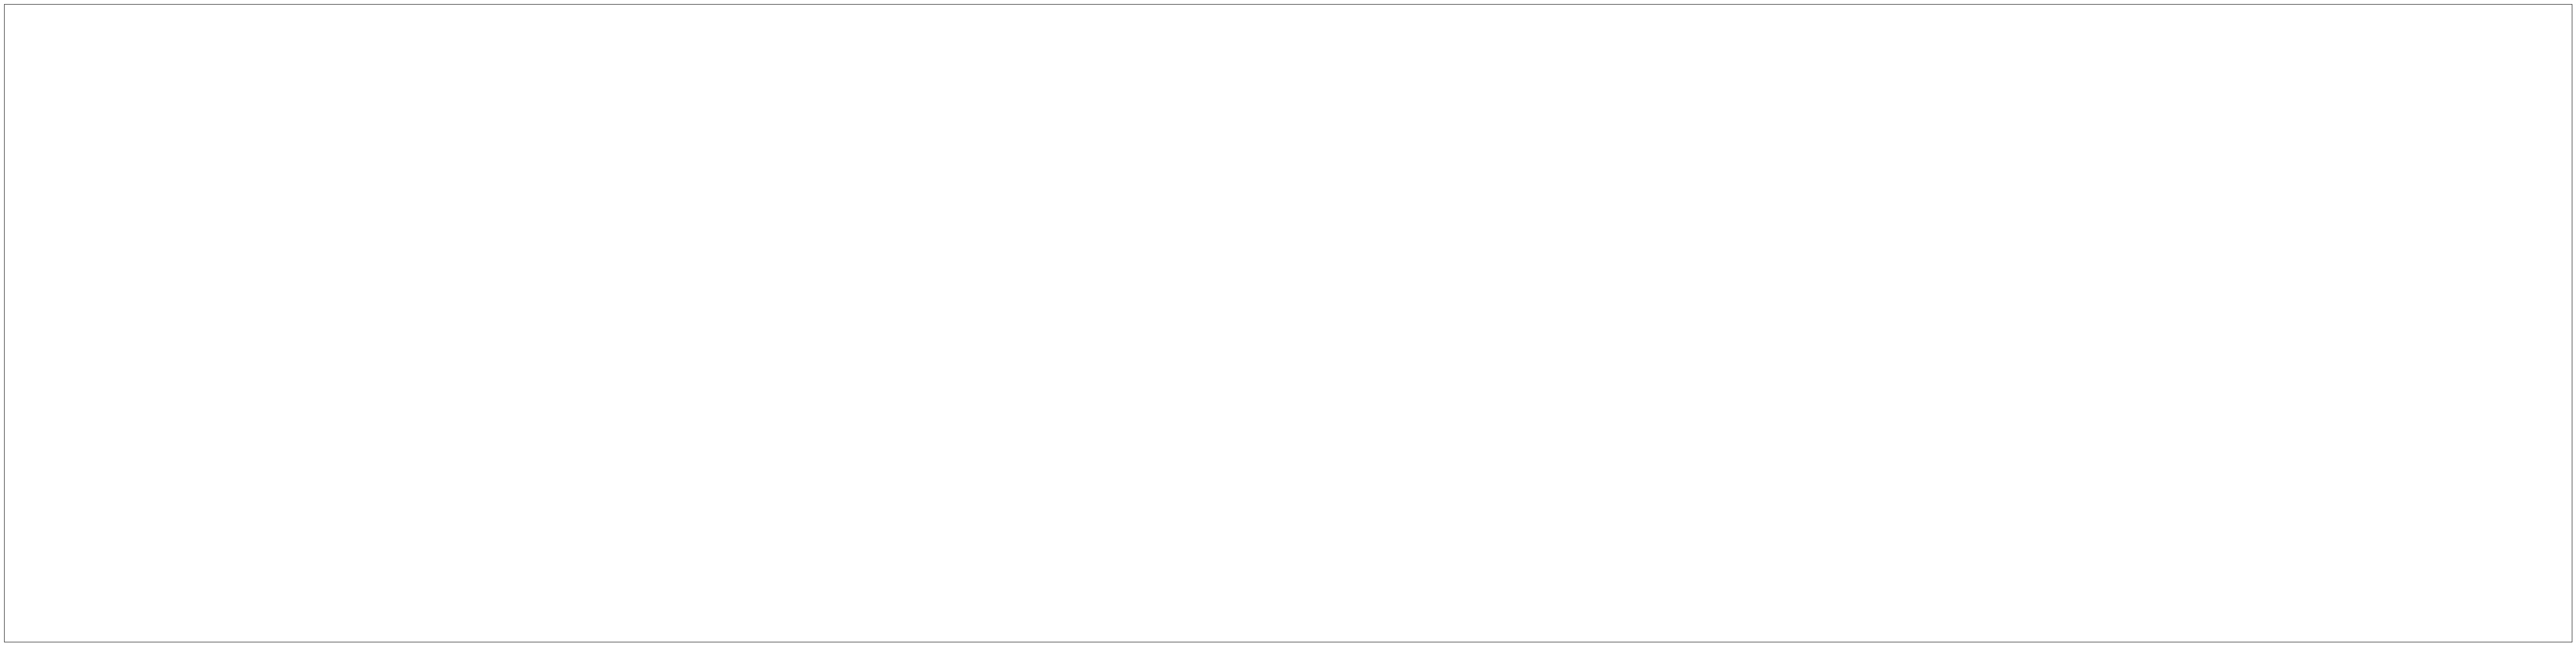

In [48]:


draw_graph(G_VOL, test_name)

In [49]:

set_task_position(G_VOL, task_file_map)

G_VOL = set_task_file_dset_pos(G_VOL, task_file_map)

# display_all_nodes_attr(G_VOL)
# print(task_file_map)

# for e in G_VOL.edges:
#     print(e)

    

task_name: arldm_train, task_order: 0
node arldm_train : {'arldm_train': {'rpos': 1, 'order': 0, 'type': 'task', 'stat': {'input': ['/mnt/common/mtang11/experiments/ARLDM/output_data/flintstones_out.h5'], 'io_cnt': 238, 'order': 0, 'output': []}}}, pos: (0, 0)


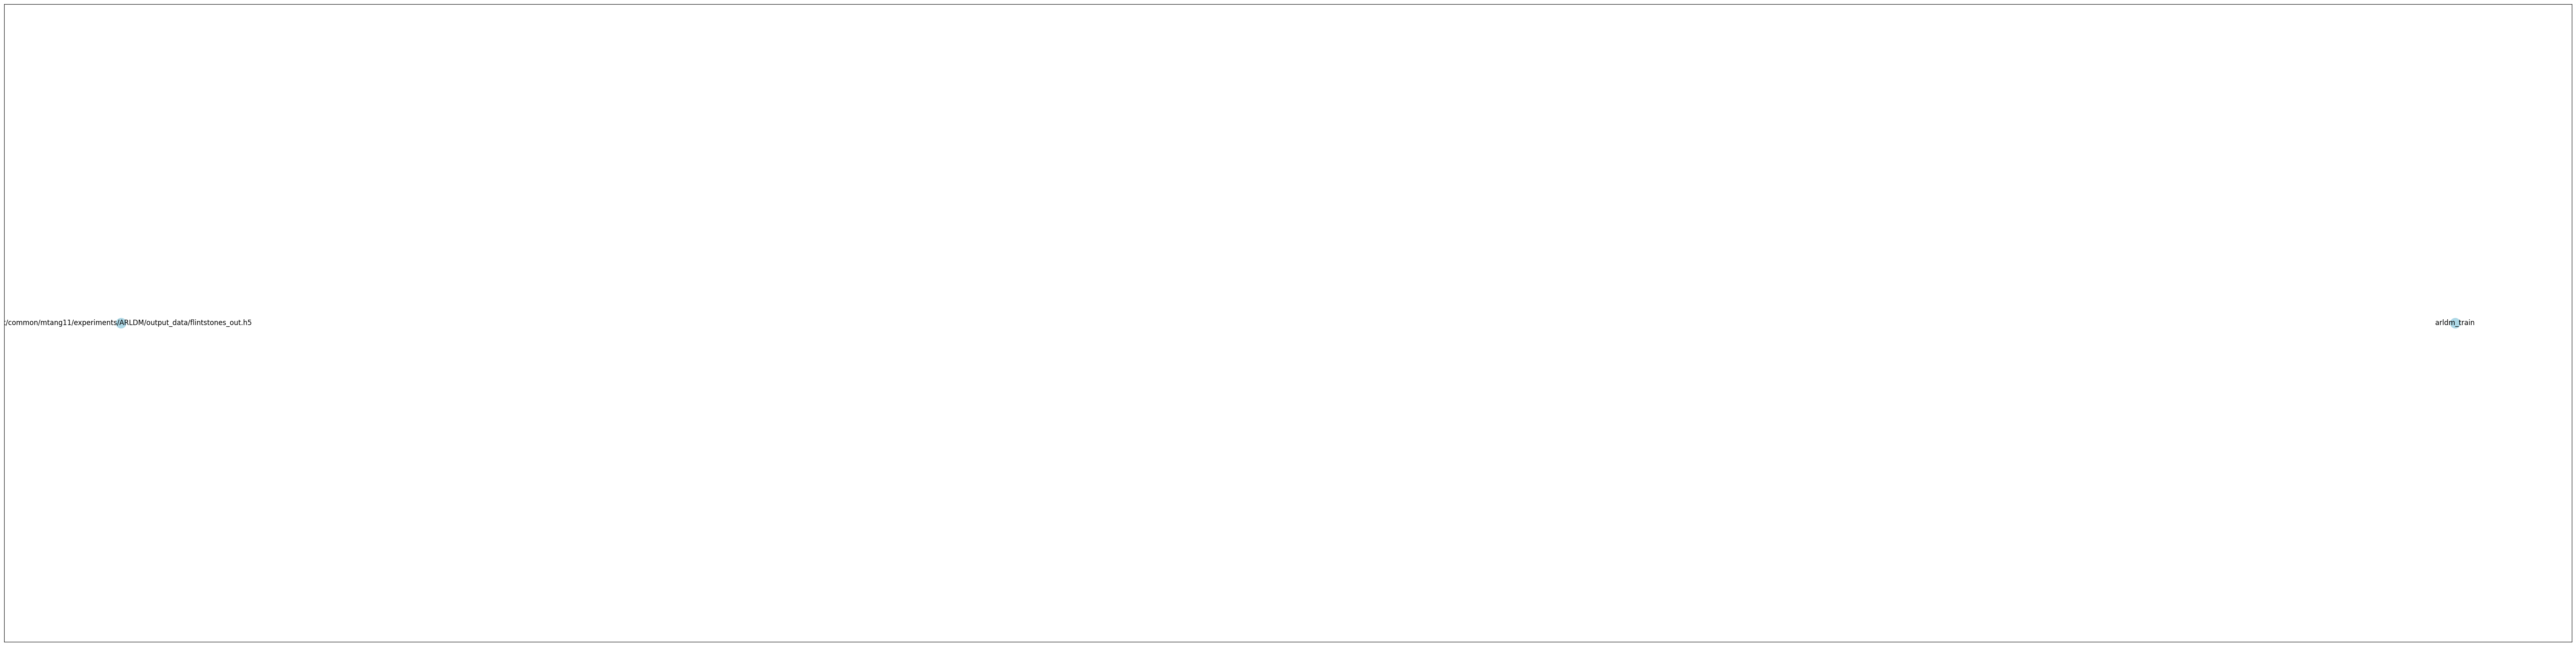

In [50]:
draw_graph(G_VOL, test_name, prefix=f'{(SELECT_STAGE_END+1)}s', save=True)

# Add networkx to Sankey diagram

## Statistics for Sankey
Below are needed edge attributes before generating the sankey diagram:
- access_cnt : The total file/dataset access count 
- access_size : The total read and write access size
- operation : The operation type : read, write, read_write
- bandwidth : Get the per access size and time, then calculate the bandwidth. Average the bandwidth if multiple accesses. (TODO: currently only recording one access size and time)


In [51]:
def prepare_sankey_stat(G):
    # TODO: makesure to add stats to all file node previously!
    all_edge_stats = nx.get_edge_attributes(G,'stat')
    all_edge_access_cnt = nx.get_edge_attributes(G,'access_cnt')

    sankey_edge_attr = {}

    for edge, stats in all_edge_stats.items():
        # all use dataset stats
        total_access_cnt = all_edge_access_cnt[edge]
        stats = all_edge_stats[edge]
        access_cnt = stats['dataset_read_cnt'] + stats['dataset_write_cnt']
        acesss_size = stats['total_bytes_read'] + stats['total_bytes_written']
        access_time_in_sec = (stats['end_time'] - stats['start_time'])/1000000
        bandwidth = total_access_cnt * (acesss_size / access_time_in_sec)

        edge_attr = {
                'access_cnt': access_cnt,
                'access_size': acesss_size,
                'operation': stats['access_type'],
                'bandwidth': bandwidth}
        sankey_edge_attr[edge] = edge_attr
    
    nx.set_edge_attributes(G, sankey_edge_attr)

prepare_sankey_stat(G_VOL)


In [52]:
def in_node_time_to_x(G,task,time_label, node_range=0.5,file_stat=False):
    # check if time_label is tring
    if type(time_label) != str:
        print('time_label should be string')
        return
    in_edges = list(G.in_edges(task))
    # print(f'{task} In edges: ', in_edges)
    in_nodes = [edge[0] for edge in in_edges]

    # get in files x_pos
    in_nodes_x_pos = [G.nodes[file]['pos'][0] for file in in_nodes]
    if in_nodes_x_pos == []:
        return
        
    # remove files not in the same curr_x_pos
    curr_x_pos = max(in_nodes_x_pos)
    in_nodes = [file for file in in_nodes if G.nodes[file]['pos'][0] == curr_x_pos and G.nodes[file]['rpos'] == 1]
        
    if in_nodes == []:
        return
    
    # get open time ranks from edge stats
    in_nodes_opentime = []
    # try:
    #     in_nodes_opentime = [G.edges[file,task]['stat'][time_label] for file in in_nodes]
    # except:
    #     for file in in_nodes:
    #         print(f'{file} {task} edge [{time_label}] not found : {G.edges[file,task]}')

    if file_stat:
        # select nodes with file type
        in_nodes = [node for node in in_nodes if G.nodes[node]['type'] == 'file']

        try:
            in_nodes_opentime = [G.nodes[file]['stat'][time_label] for file in in_nodes]
        except:
            for node in in_nodes:
                node_type = G.nodes[node]['type']
                if node_type != 'file':
                    print(f'{node} is of type [{node_type}] has no [{time_label}] attributes ...')
                in_nodes.remove(node)
            in_nodes_opentime = [G.edges[file,task]['stat'][time_label] for file in in_nodes]
    else:
        in_nodes_opentime = [G.edges[file,task]['stat'][time_label] for file in in_nodes]

    # in_nodes_opentime = [G.nodes[file]['stat'][time_label] for file in in_nodes]

    if len(in_nodes_opentime) > 1:
        in_nodes_opentime_rank = rankdata(in_nodes_opentime)
        # only normalize between 0 and up to padding, save space between task
        normalized_opentime_ranks = [node_range * (rank - 1) / (len(in_nodes_opentime_rank) - 1) for rank in in_nodes_opentime_rank]
    else:
        normalized_opentime_ranks = [0.0]

    for i,file in enumerate(in_nodes):
        new_x_pos = curr_x_pos + normalized_opentime_ranks[i]
        y_pos = G.nodes[file]['pos'][1]
        G.nodes[file]['pos'] = (new_x_pos, y_pos)
        # G.nodes[file]['pos'][1] = G.nodes[task]['pos'][1]
        print(f'{file} New pos: ', G.nodes[file]['pos'])
        G.nodes[file]['rpos'] = 2 # mark as added time to x_pos


def out_node_time_to_x(G,task, time_label, node_range=0.5,file_stat=False):
    # check if time_label is tring
    if type(time_label) != str:
        print('time_label should be string')
        return

    out_edges = list(G.out_edges(task))
    out_fiels = [edge[1] for edge in out_edges]

    # get out files x_pos
    out_nodes_x_pos = [G.nodes[file]['pos'][0] for file in out_fiels]
    if out_nodes_x_pos == []:
        return

    # remove files not in the same curr_x_pos
    curr_x_pos = min(out_nodes_x_pos)
    out_nodes = [file for file in out_fiels if G.nodes[file]['pos'][0] == curr_x_pos and G.nodes[file]['rpos'] == 1]

    if out_nodes == []:
        return
    
    # get close time ranks from edge stats
    if file_stat:
        # select nodes with file type
        out_nodes = [node for node in out_nodes if G.nodes[node]['type'] == 'file']
        out_nodes_closetime = [G.nodes[file]['stat'][time_label] for file in out_nodes]
    else:
        out_nodes_closetime = [G.edges[task,file]['stat'][time_label] for file in out_fiels]
    # out_nodes_closetime = [G.nodes[file]['stat'][time_label] for file in out_fiels]

    if len(out_nodes_closetime) > 1:
        out_nodes_closetime_rank = rankdata(out_nodes_closetime)
        # only normalize between 0 and 0.5, save space between task
        normalized_closetime_ranks = [node_range * (rank - 1) / (len(out_nodes_closetime_rank) - 1) for rank in out_nodes_closetime_rank]
    else:
        normalized_closetime_ranks = [0.0]
    
    for i,file in enumerate(out_fiels):
        new_x_pos = curr_x_pos - normalized_closetime_ranks[i]
        y_pos = G.nodes[file]['pos'][1]
        G.nodes[file]['pos'] = (new_x_pos, y_pos)
        # G.nodes[file]['pos'][1] = G.nodes[task]['pos'][1]
        print(f'{file} New pos: ', G.nodes[file]['pos'])
        G.nodes[file]['rpos'] = 2

    # print(f'{task} Out files: ', out_fiels)
        
def time_to_file_x_pos(G):
    all_tasks = list([node for node in G.nodes() if G.nodes[node]['type'] == 'task'])
    node_range = 0.3
    # print('All tasks: ', all_tasks)
    for i,task in enumerate(all_tasks):
        # get in edges files time to x_pos
        in_node_time_to_x(G,task,'start_time', node_range=node_range)
        # get out edges files time to x_pos
        if i == len(all_tasks) - 1:
            out_node_time_to_x(G,task, 'end_time', node_range=node_range)
    
    all_datasets = list([node for node in G.nodes() if G.nodes[node]['type'] == 'dataset'])
    for i,dset in enumerate(all_datasets):
        # get in edges files time to x_pos
        in_node_time_to_x(G,dset, 'open_time', node_range=node_range,file_stat=True)
        # get out edges files time to x_pos
        if i == len(all_tasks) - 1:
            out_node_time_to_x(G,task, 'close_time', node_range=node_range,file_stat=True)
        # out_node_time_to_x(G,dset, 'close_time', node_range=node_range)


time_to_file_x_pos(G_VOL)

In [53]:
# Sankey related codes
EDGE_COLOR_RGBA = {
    'none' : {'r':180, 'g':180, 'b':180}, #grey for open/close/meta
    'read_only' : {'r':150, 'g':190, 'b':220},
    'write_only' : {'r':150, 'g':190, 'b':220},
    'read_write' : {'r':150, 'g':190, 'b':220},
    # 'write' : {'r':140, 'g':210, 'b':220},
}

# color names : https://www.w3schools.com/colors/colors_names.asp
COLOR_MAP = {"task": "Red", # read
            "dataset": "Gold", # yellow
            "file": "MediumBlue", # blue
            "none": "grey",
            }
OPACITY = 0.6


def get_xy_position(G):
    pos_dict = nx.get_node_attributes(G,'pos')

    x_dict = {}
    y_dict = {}
    for n, pos in pos_dict.items():
        x_dict[n] = pos[0]
        y_dict[n] = pos[1]
    
    # shift x position to start from 0
    if len(x_dict.values()) == 0:
        x_base = 0
        xf = 1
    else:
        x_base= min(x_dict.values())
        xf=1.0/(max(x_dict.values()))
    x_dict = {k: v-x_base for k, v in x_dict.items()}
    # normalize x positions
    x_normalized = {k: v*xf for k, v in x_dict.items() }
    
    # # normalize y positions
    # yf=1.0/(max(y_dict.values()))
    # y_normalized = {k: v*yf for k, v in y_dict.items() }

    # normalize y positions
    y_max = max(y_dict.values())
    y_min = min(y_dict.values())
    # Noamalize y positions between 0.1 and 1
    y_normalized = {k: 0.01 + 0.99 * (v - y_min) / (y_max - y_min) for k, v in y_dict.items()}
    
    return x_normalized, y_normalized

def get_nodes_for_sankey(G, rm_tags=[],label_on=True):
    node_dict_ref = {}
    node_dict_for_sankey = {'label': [], 'color':[], 'x':[], 'y':[] }
    x_pos, y_pos = get_xy_position(G)
    
    for idx, (node_name, attr) in enumerate(G.nodes(data=True)):
        # node_type = 'file' if node_name[-4:] == 'residue_100.h5' else 'task'
        # print(f"{idx}, ({node_name}, {attr})")
        
        node_type = attr['type']
        if node_name in node_dict_ref:
            print(node_name, "==duplicate==")
        node_dict_ref[node_name] = {'idx':idx, 'type':node_type}

        #sankey
        if label_on :  
            # node_label = node_name + f" {G.nodes[node_name]['pos']} ({x_pos[node_name]:.2f}, {y_pos[node_name]:.2f})"
            node_label = node_name
            node_dict_for_sankey['label'].append(node_label)
        node_dict_for_sankey['color'].append(COLOR_MAP[node_type])
        node_dict_for_sankey['x'].append(x_pos[node_name])
        node_dict_for_sankey['y'].append(y_pos[node_name])
    return node_dict_for_sankey, node_dict_ref


def edge_color_scale(attr_bw, attr_op, bw, op):
    range = 100

    base_color_dict = {}
    if op in EDGE_COLOR_RGBA.keys():
        base_color_dict = EDGE_COLOR_RGBA[op]
        r = base_color_dict['r']
        g = base_color_dict['g']
        b = base_color_dict['b']
    else:
        base_color_dict = EDGE_COLOR_RGBA['none']
        r = base_color_dict['r']
        g = base_color_dict['g']
        b = base_color_dict['b']
        color_str = f"rgba({r}, {g}, {b}, {OPACITY})"
        return color_str

    edges = []
    for k,v in attr_op.items():
        if v == op:
            edges.append(k)
    # bw_list = list(set(attr_bw.values()))
    bw_list = [attr_bw[x] for x in edges]
    bw_list.sort()
    # print(bw_list)
        
    color_ranks = rankdata(bw_list,method='dense')
    color_ranks = [float(i)/max(color_ranks) for i in color_ranks] # normalize

    my_rank = color_ranks[bw_list.index(bw)]

    color_change = my_rank *range #(my_rank-1)
    op_change = (my_rank/max(color_ranks)) * 0.5 + 0.4
    color_str = f"rgba({r-color_change/1.5}, {g-color_change/1.5}, {b-color_change/1.5}, {op_change})"

    # print(f"{color_str} rank={my_rank} sqrt={math.sqrt(my_rank)} change={color_change}")
    return color_str

def get_links_for_sankey(G, node_dict_ref,edge_attr=['access_cnt','access_size','operation','bandwidth'],rm_tags=[],val_sqrt=True):
    link_dict_for_sankey = {'source':[], 'target':[], 'value':[], 'label': [], 'color': []}
    #'hoverinfo': "all"
    #'line_width':[], # shows strokeWidth of the edges
    
    attr_cnt = nx.get_edge_attributes(G,edge_attr[0])
    attr_size = nx.get_edge_attributes(G,edge_attr[1])
    attr_op = nx.get_edge_attributes(G,edge_attr[2])
    attr_bw = nx.get_edge_attributes(G,edge_attr[3])
    
    
    # min_size = min(attr_size.values())
    
    # print(attr_dict)
    for u, v, attr in G.edges(data=True):
        if u in node_dict_ref.keys() and v in node_dict_ref.keys():
            # print(u, v, attr)
            u_idx = node_dict_ref[u]['idx']
            v_idx = node_dict_ref[v]['idx']
            link_dict_for_sankey['source'].append(u_idx)
            link_dict_for_sankey['target'].append(v_idx)

            cnt = attr_cnt[(u,v)]
            size = attr_size[(u,v)]
            if val_sqrt: graph_size = size**(1/4) #math.sqrt(size)
            else: graph_size = size
            
            if cnt == 0: cnt = 1
            if size == 0: graph_size = 1
            
            op = attr_op[(u,v)]

            # get edge color based on bandwidth
            link_dict_for_sankey['value'].append(graph_size)
            # _str = f"ave_acc_size: {humansize(size/cnt)} op: {op}"
            bw = attr_bw[(u,v)]
            _str = (f"Access Volume : {humansize(size)} <br />"
                + f"Access Count : {cnt} <br />"
                + f"Average Access Size : {humansize(size/cnt)} <br />"
                + f"Operation : {op}<br />"
                +f"Bandwidth : {humanbw(bw)}")
            
            link_dict_for_sankey['label'].append(_str)

            link_dict_for_sankey['color'].append(edge_color_scale(attr_bw, attr_op, bw, op)) # get the last operation
            
            # link_dict_for_sankey['acc_cnt'].append(cnt)
    
    print(f"bandwidth range: {humanbw(min(attr_bw.values()))} ~ {humanbw(max(attr_bw.values()))}")
        
    return link_dict_for_sankey

def selected_graph(node_name, G):
    # this is not used
    selected_G = nx.DiGraph()
    search_nodes = [node_name]
    while len(search_nodes) > 0:
        next_set = []
        for n in search_nodes:
            for edge in G.edges(n):
                val = G.edges[edge]['value']
                selected_G.add_edges_from([edge], value=val)
                #print(selected_G.nodes)
            next_set += [x for x in G.neighbors(n)]
        search_nodes = next_set
    return selected_G

In [54]:
vol_nodes, vol_nodes_dict = get_nodes_for_sankey(G_VOL, label_on=True)

# print(vol_nodes)

vol_links = get_links_for_sankey(G_VOL, vol_nodes_dict)
fig = go.Figure(go.Sankey(
            node = vol_nodes,
            link = vol_links, orientation='h'))



ZeroDivisionError: float division by zero

In [ ]:
fig.update_layout(
    autosize=False,
    width=4400,
    height=6200,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=2000,
    ),
)
fig.show()

saved_image_path = f"{stat_path}/vol-{(SELECT_STAGE_END+1)}s-{test_name}-sankey.html"

fig.write_html(saved_image_path)
print(f"saved to : {saved_image_path}")

saved to : ../example_stat/seq9f9s/vol-5s-seq9f9s-sankey.html


In [ ]:
DATASET_LIMIT = 10

for node, node_attr in vol_nodes.items():
    print(f"{node} : {node_attr}")

print()

vol_nodes_new_dict = {}
dset_count = 0

for node, attr in vol_nodes_dict.items():    
    vol_nodes_new_dict[node] = attr
    # print(f"{node} : {attr}")
    if attr['type'] == 'dataset':
        dset_count+=1
    if dset_count >= DATASET_LIMIT:
        break

print()
        
for node, attr in vol_nodes_new_dict.items():
    print(f"{node} : {attr}")

# get index of selected nodes
wanted_nodes_index = []
for idx, node in enumerate(vol_nodes['label']):
    if node in vol_nodes_new_dict.keys():
        wanted_nodes_index.append(idx)

print(f"wanted_nodes_index: {wanted_nodes_index}")

# select wanted nodes with attributes
vol_new_nodes = {}
for key, val in vol_nodes.items():
    vol_new_nodes[key] = [val[i] for i in wanted_nodes_index]

print(f"New nodes: ")
for node, node_attr in vol_new_nodes.items():
    print(f"{node} : {node_attr}")

# # select wanted links with attributes
# vol_new_links = {}
# for key, val in vol_links.items():
#     vol_new_links[key] = [val[i] for i in wanted_nodes_index]

# print(f"New links: ")
# for link, attr in vol_new_links.items():
#     print(f"{link} : {attr}")



label : ['trackstats_20150506.0000_20150506.0800.nc', 'tracks-read', 'run_trackstats', 'times-read', 'track_duration-read', 'base_time-read', 'meanlat-read', 'meanlon-read', 'area-read', 'cloudnumber-read', 'track_status-read', 'track_interruptions-read', 'merge_tracknumbers-read', 'split_tracknumbers-read', 'core_area-read', 'cold_area-read', 'corecold_mintb-read', 'corecold_meantb-read', 'core_meantb-read', 'lat_mintb-read', 'lon_mintb-read', 'start_status-read', 'end_status-read', 'start_basetime-read', 'end_basetime-read', 'start_split_tracknumber-read', 'start_split_timeindex-read', 'start_split_cloudnumber-read', 'end_merge_tracknumber-read', 'end_merge_timeindex-read', 'end_merge_cloudnumber-read', 'trackstats_sparse_20150506.0000_20150506.0800.nc', 'sparse_index-read', 'tracks_indices-read', 'times_indices-read', 'mcs_tracks_20150506.0000_20150506.0800.nc', 'run_identifymcs', 'mergers-read', 'merge_cloudnumber-read', 'split_ccs_area-read', 'split_cloudnumber-read', 'merge_ccs_a

In [ ]:
vol_new_links = get_links_for_sankey(G_VOL, vol_nodes_new_dict, val_sqrt=False)

fig = go.Figure(go.Sankey(
            node = vol_new_nodes,
            link = vol_new_links, orientation='h'))

fig.update_layout(
    autosize=False,
    width=1800,
    height=800,
    margin=dict(
        l=10,
        r=50,
        b=50,
        t=250,
    ),
    font=dict(size=18),
)
fig.show()

saved_image_path = f"{stat_path}/vol-{(SELECT_STAGE_END+1)}s-{test_name}-sankey-{DATASET_LIMIT}dset.html"

fig.write_html(saved_image_path)
print(f"saved to : {saved_image_path}")

bandwidth range: 0 ~ 0


saved to : ../example_stat/seq9f9s/vol-5s-seq9f9s-sankey-10dset.html
